## Step 0. Data Science connection to Duet Network Server

#### DS - Part 2: Join the Duet Server the Data Owner 1 connected to

In [1]:
import syft as sy
duet = sy.duet("e22d0fbaec9bfe339f4aaa58c7af83cf", network_url="http://52.19.68.70:5000")

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://52.19.68.70:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following Duet Client ID to your duet partner!
♫♫♫ > Duet Client ID: a2e3078377de813a984bda2dc82ade85

♫♫♫ > ...waiting for partner to connect...

♫♫♫ > CONNECTED!


## Step 1. Check available data

In [2]:
duet.store.pandas

,ID,Tags,Description,object_type
0,<UID: 48484ccdfd824753ab4615650e3b19fd>,[x_data_train],X Train - synthetic regression dataset,<class 'torch.Tensor'>
1,<UID: 80e284f551d74562a47b0f5d0485e606>,[y_data_train],Y Train - synthetic regression dataset,<class 'torch.Tensor'>
2,<UID: 48c985b098ea459f9f3e8f1fc2287779>,[x_data_test],X Test - synthetic regression dataset,<class 'torch.Tensor'>
3,<UID: b030dc0de3404c42a581a27427cc1263>,[y_data_test],Y Test - synthetic regression dataset,<class 'torch.Tensor'>


In [3]:
X_train_ptr = duet.store['x_data_train']
Y_train_ptr = duet.store['y_data_train']

X_test_ptr = duet.store['x_data_test']
Y_test_ptr = duet.store['y_data_test']


print(X_train_ptr)
print(Y_train_ptr)

print(X_test_ptr)
print(Y_test_ptr)

## Step.2. Pysyft Model definition

We are trying to learn the unknown parameters (a,b) y = a*x + b. Thus, we define a model that applies this linear transformation to the training data x in order to predict ŷ. We will use MSE loss to adjust the parameters (a,b) using the y true value

In [4]:
import torch

In [5]:
input_size = 1 # input features 
output_size = 1 # output features

In [6]:
class linearRegression(sy.Module):
    def __init__(self, torch_ref):
        super(linearRegression, self).__init__(torch_ref=torch_ref)
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
torch_model = linearRegression(torch)

In [8]:
print(torch_model)

## Step 3.a PySyft Model training 

This is the most common implementation of a PySyft model trainer in Duet.

In [9]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()
        output = model(data_ptr)
        loss = torch_ref.nn.functional.mse_loss(output, target_ptr)
        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress",
            request_block=True,
            timeout_secs=5,
        )

        print("Epoch", i, "loss", loss_value)
        losses.append(loss_value)
        loss.backward()
        optim.step()

    return losses

### Training

Train on Data Owner 1 data

In [10]:
remote_model1 = torch_model.send(duet)

In [11]:
remote_torch1 = duet.torch
params = remote_model1.parameters()
optim1 = remote_torch1.optim.Adam(params=params, lr=0.1)

In [12]:
iteration = 10
losses = train(iteration, remote_model1, remote_torch1, optim1, X_train_ptr, Y_train_ptr)

Epoch 0 loss 446.00042724609375
Epoch 1 loss 445.6488037109375
Epoch 2 loss 445.3446350097656
Epoch 3 loss 445.0885925292969
Epoch 4 loss 444.8802795410156
Epoch 5 loss 444.718505859375
Epoch 6 loss 444.600830078125
Epoch 7 loss 444.5234680175781
Epoch 8 loss 444.4811706542969
Epoch 9 loss 444.4670104980469


#### Sanity check: remote model parameters vs. base model parameters

In [13]:
param1 = remote_model1.parameters().get(request_block=True)

print("Base Model parameters:")
print(torch_model.parameters())
print()

print("Remote model parameters:")
print(param1)
print()

assert(torch_model.parameters()!= param1)

Base Model parameters:
[Parameter containing:
tensor([[-0.8546]], requires_grad=True), Parameter containing:
tensor([-0.0342], requires_grad=True)]

Remote model parameters:
[Parameter containing:
tensor([[-0.0161]], requires_grad=True), Parameter containing:
tensor([0.8701], requires_grad=True)]



The remote model paramter values are different from the base model paramter values. That means the remote copies of our base model got trained and updated.

## Step 4. Retrieve the model (parameters)

In [14]:
remote_model1_updates = remote_model1.get(
    request_block=True
).state_dict()

print(remote_model1_updates)

OrderedDict([('linear.weight', tensor([[-0.0161]])), ('linear.bias', tensor([0.8701]))])


In [15]:
final_model = linearRegression(torch)

We instantiate a base model and update the parameters of this base model with the ones retrieve from Duet Data Owner data.

In [16]:
final_model.load_state_dict(remote_model1_updates)

## Step 5. Performance evaluation

Retrieve test dataset to evaluate the model.

In [17]:
x_test_data = X_test_ptr.get(request_block=True)
y_test_data = Y_test_ptr.get(request_block=True)

In [19]:
x_test_data.shape, y_test_data.shape

(torch.Size([125, 1]), torch.Size([125, 1]))

Execute some predictions

In [20]:
preds = []
with torch.no_grad():
    for i in range(len(x_test_data)):
        sample = x_test_data[i]
        y_hat = final_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {y_test_data[i].item()}")
        preds.append(y_hat)

Prediction: 0.8583133220672607 Ground Truth: -24.165260314941406
Prediction: 0.8604386448860168 Ground Truth: 11.418693542480469
Prediction: 0.8553639054298401 Ground Truth: -15.858510971069336
Prediction: 0.8693671226501465 Ground Truth: -0.13584725558757782
Prediction: 0.857445478439331 Ground Truth: -3.936762809753418
Prediction: 0.8577141165733337 Ground Truth: 41.63837432861328
Prediction: 0.8622026443481445 Ground Truth: 11.748366355895996
Prediction: 0.8607022762298584 Ground Truth: 34.149566650390625
Prediction: 0.8611084818840027 Ground Truth: 29.03923225402832
Prediction: 0.8676490783691406 Ground Truth: 16.36427116394043
Prediction: 0.8554822206497192 Ground Truth: 5.5443549156188965
Prediction: 0.8641954660415649 Ground Truth: 5.839398384094238
Prediction: 0.8622543811798096 Ground Truth: -4.988951683044434
Prediction: 0.866599440574646 Ground Truth: 22.329248428344727
Prediction: 0.8543064594268799 Ground Truth: -55.02419662475586
Prediction: 0.8646013140678406 Ground Trut

### Visualization of predicted regression line

In [21]:
syft_preds = final_model(x_test_data)

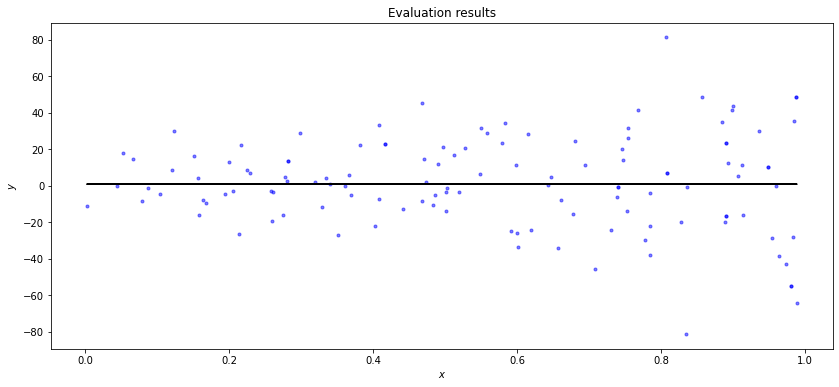

In [28]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14,6))
plt.title("Evaluation results")
#plt.plot(x_t, y_t, '.', alpha=0.5, color='green' ) 
plt.plot(x_test_data, y_test_data, '.', alpha=0.5, color='blue' ) 
plt.plot(x_test_data, syft_preds.detach().numpy(), color='black' ) 
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.show()

In [4]:
duet2.store.pandas

,ID,Tags,Description
0,<UID: e5b6c9c74cb4408aa4f4953d8e5041da>,[DO2 data],"Dataset of 5 samples, 1 feature"


## Linear regression

In [5]:
data1_ptr = duet1.store[0]
data2_ptr = duet2.store[0]

print(data1_ptr)
print(data2_ptr)

### Create Base Model

In [6]:
import torch

In [7]:
in_dim = 1
out_dim = 1

In [8]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.linear = self.torch_ref.nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = self.linear(x)
        return x

### Training

In [9]:
def train(iterations, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data_ptr)

        loss = torch_ref.nn.functional.mse_loss(output, target_ptr)

        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress",
            request_block=True,
            timeout_secs=5,
        )

        print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses

#### Send one copy of the model to each data owner or client and train them remotely one by one

In [10]:
import torch as th
import numpy as np

In [11]:
base_model = SyNet(torch)

> Creating local model


Train on Data Owner 1 data

In [12]:
remote_model1 = base_model.send(duet1)

> Sending local model
> Creating remote model
  Sending local layer: linear

> Finished sending local model <




In [13]:
remote_torch1 = duet1.torch
params = remote_model1.parameters()
optim1 = remote_torch1.optim.Adam(params=params, lr=0.1)

Dummy target data

In [14]:
target1_ptr = th.FloatTensor(np.array([5, 10, 15, 22, 30, 38]).reshape(-1, 1))
target1_ptr

tensor([[ 5.],
        [10.],
        [15.],
        [22.],
        [30.],
        [38.]])

In [15]:
iteration = 10
losses = train(iteration, remote_model1, remote_torch1, optim1, data1_ptr, target1_ptr)

Epoch 0 loss 1050.6131591796875
Epoch 1 loss 833.8958129882812
Epoch 2 loss 643.0696411132812
Epoch 3 loss 478.4125671386719
Epoch 4 loss 339.91876220703125
Epoch 5 loss 227.21815490722656
Epoch 6 loss 139.4890899658203
Epoch 7 loss 75.3707046508789
Epoch 8 loss 32.8933219909668
Epoch 9 loss 9.448577880859375


Train on Data Owner 2 data

In [16]:
remote_model2 = base_model.send(duet2)

> Sending local model
> Creating remote model
  Sending local layer: linear

> Finished sending local model <




In [17]:
remote_torch2 = duet2.torch
params = remote_model2.parameters()
optim2 = remote_torch2.optim.Adam(params=params, lr=0.1)

Dummy Target data

In [18]:
target2_ptr = th.FloatTensor(np.array([35, 40, 45, 55, 60]).reshape(-1, 1))
target2_ptr

tensor([[35.],
        [40.],
        [45.],
        [55.],
        [60.]])

In [19]:
iteration = 10
losses = train(iteration, remote_model2, remote_torch2, optim2, data2_ptr, target2_ptr)

Epoch 0 loss 4783.2255859375
Epoch 1 loss 3764.81591796875
Epoch 2 loss 2872.36083984375
Epoch 3 loss 2107.156494140625
Epoch 4 loss 1469.0284423828125
Epoch 5 loss 955.904296875
Epoch 6 loss 563.3424682617188
Epoch 7 loss 284.0714416503906
Epoch 8 loss 107.63623046875
Epoch 9 loss 20.289325714111328


### Averaging Model Updates

Ideally, there will be a coordinator server with a secure aggreagtor who will get the model updates from different clients and make an aggregation. For the case of simplicity, in this example we will make the Data Sceintist server work as the coordinator.

### Little sanity check!

In [20]:
param1 = remote_model1.parameters().get(request_block=True)
param2 = remote_model2.parameters().get(request_block=True)

print("Base Model parameters:")
print(base_model.parameters())
print()

print("Remote model1 parameters:")
print(param1)
print()

print("Remote model2 parameters:")
print(param2)

Base Model parameters:
[Parameter containing:
tensor([[-0.2793]], requires_grad=True), Parameter containing:
tensor([0.2700], requires_grad=True)]

Remote model1 parameters:
[Parameter containing:
tensor([[0.6305]], requires_grad=True), Parameter containing:
tensor([1.1781], requires_grad=True)]

Remote model2 parameters:
[Parameter containing:
tensor([[0.6246]], requires_grad=True), Parameter containing:
tensor([1.1733], requires_grad=True)]


As you can see, the remote model paramter values are different from the base model paramter values. That means the remote copies of our base model got trained and updated.

In [21]:
remote_model1_updates = remote_model1.get(
    request_block=True
).state_dict()

print(remote_model1_updates)

> Downloading remote model
> Creating local model

> Finished downloading remote model <


> Saving model weights
> Finished saving weights
OrderedDict([('linear.weight', tensor([[0.6305]])), ('linear.bias', tensor([1.1781]))])


In [22]:
remote_model2_updates = remote_model2.get(
    request_block=True
).state_dict()

print(remote_model2_updates)

> Downloading remote model
> Creating local model

> Finished downloading remote model <


> Saving model weights
> Finished saving weights
OrderedDict([('linear.weight', tensor([[0.6246]])), ('linear.bias', tensor([1.1733]))])


In [23]:
from collections import OrderedDict

Let's do the aggregation of the weights. In this example, we will just calculate the average of corresponding weights from each model.

In [24]:
avg_updates = OrderedDict()
avg_updates["linear.weight"] = (
    remote_model1_updates["linear.weight"] + remote_model2_updates["linear.weight"]
) / 2
avg_updates["linear.bias"] = (
    remote_model1_updates["linear.bias"] + remote_model2_updates["linear.bias"]
) / 2

print(avg_updates)

OrderedDict([('linear.weight', tensor([[0.6276]])), ('linear.bias', tensor([1.1757]))])


### Load aggregated weights

In [25]:
combined_model = SyNet(torch)

> Creating local model


In [26]:
combined_model.load_state_dict(avg_updates)

> Loading model weights
linear state dict loaded with: <All keys matched successfully>
> Finished loading weights


In [27]:
del avg_updates, remote_model1_updates, remote_model2_updates

In [28]:
test_data = th.FloatTensor(np.array([17, 25, 32, 50, 80]).reshape(-1, 1))
test_target = th.FloatTensor(np.array([12, 15, 20, 30, 50]).reshape(-1, 1))

In [29]:
preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        sample = test_data[i]
        y_hat = combined_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {test_target[i].item()}")
        preds.append(y_hat)

Prediction: 11.84467887878418 Ground Truth: 12.0
Prediction: 16.86537742614746 Ground Truth: 15.0
Prediction: 21.25848960876465 Ground Truth: 20.0
Prediction: 32.5550651550293 Ground Truth: 30.0
Prediction: 51.382686614990234 Ground Truth: 50.0


In [30]:
preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        sample = test_data[i]
        y_hat = base_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {test_target[i].item()}")
        preds.append(y_hat)

Prediction: -4.478724956512451 Ground Truth: 12.0
Prediction: -6.713418483734131 Ground Truth: 15.0
Prediction: -8.66877555847168 Ground Truth: 20.0
Prediction: -13.696836471557617 Ground Truth: 30.0
Prediction: -22.076936721801758 Ground Truth: 50.0


## Comparison to classical linear regression on centralised data

In [ ]:
import torch
import numpy as np

in_dim = 1
out_dim = 1


class ClassicalLR(torch.nn.Module):
    def __init__(self, torch):
        super(ClassicalLR, self).__init__()
        self.linear = torch.nn.Linear(in_dim, out_dim)

    def forward(self, x):
        x = self.linear(x)
        return x


classical_model = ClassicalLR(torch)

In [ ]:
data = torch.FloatTensor(
    np.array([5, 15, 25, 35, 45, 55, 60, 65, 75, 85, 95]).reshape(-1, 1)
)
target = torch.FloatTensor(
    np.array([5, 10, 15, 22, 30, 38, 35, 40, 45, 55, 60]).reshape(-1, 1)
)

In [ ]:
def classic_train(iterations, model, torch, optim, data, target, criterion):

    losses = []

    for i in range(iterations):

        optim.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss_item = loss.item()

        if i % 10 == 0:
            print("Epoch", i, "loss", loss_item)

        losses.append(loss_item)

        loss.backward()

        optim.step()

    return losses

In [ ]:
params = classical_model.parameters()
optim = torch.optim.Adam(params=params, lr=0.1)
criterion = torch.nn.MSELoss()

In [ ]:
iteration = 100
losses = classic_train(
    iteration, classical_model, torch, optim, data, target, criterion
)

In [ ]:
test_data = th.FloatTensor(np.array([17, 25, 32, 50, 80]).reshape(-1, 1))
test_target = th.FloatTensor(np.array([12, 15, 20, 30, 50]).reshape(-1, 1))

In [ ]:
preds = []
with torch.no_grad():
    for i in range(len(test_data)):
        sample = test_data[i]
        y_hat = classical_model(sample)

        print(f"Prediction: {y_hat.item()} Ground Truth: {test_target[i].item()}")
        preds.append(y_hat)